In [1]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
import time
from pathlib import Path
import os

# Self-written modules
from yq.scripts import models
from yq.scripts import heston_func
from yq.utils import option
from yq.utils import calendar
from yq.scripts import simulation as sm
from sc import constants as cs
from sy.variance_reduction import apply_control_variates
from sy.interest_rate import populate_bond_table, get_period
from sy.calibration import apply_empirical_martingale_correction

/Users/maffinnn/Desktop/mh4518/code/yq/scripts/heston_func.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [2]:
print(cs.ASSET_NAMES)

['LONN.SW', 'SIKA.SW']


# Fetch stock data

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-10-16,426.100006,235.000000
2023-10-17,357.299988,222.199997
2023-10-18,344.700012,216.300003
2023-10-19,342.000000,218.199997
2023-10-20,332.899994,217.000000
2023-10-23,327.600006,215.899994
2023-10-24,330.899994,215.699997
2023-10-25,315.000000,212.000000
2023-10-26,315.899994,211.199997


331.3999938964844

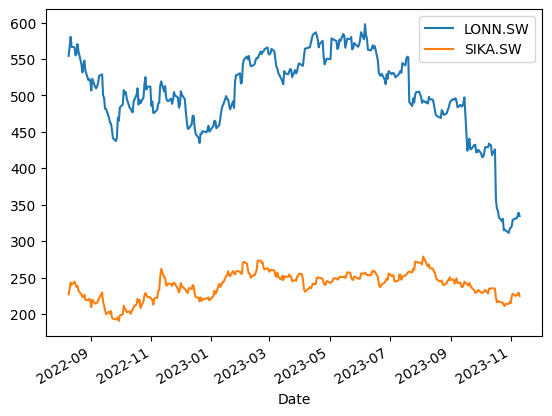

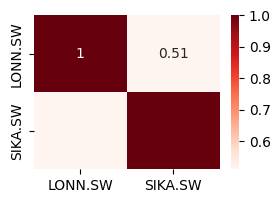

In [2]:
historical_start_date = '2022-08-09'
# Define the ticker list
ticker_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
display(data.tail(20))
data.plot()
display(data.loc['2023-11-07']['LONN.SW'])

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [3]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = calendar.SIXTradingCalendar()
gbm = models.PricingModel(params = params)

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))


### Test out get sim_data list

In [ ]:
# Copy the start_time_str from the folders
product_est_date_sim_data_df_list = sm.read_sim_data(
        model_name='gbm',
        start_time_str='20231111_185351_394318', 
        prod_est_start_date=pd.Timestamp('2023-08-09'), 
        prod_est_end_date=pd.Timestamp('2023-08-10'))
print(type(product_est_date_sim_data_df_list)[0])
n_sim_on_day = pd.concat(product_est_date_sim_data_df_list[0], axis=1)
ax = n_sim_on_day.plot(alpha=0.6, legend=False)
ax.figure.show()


In [ ]:
product_est_date_sim_data_df_list[0]


# Testing diff h (stale, refer to normal sims while creating class)

In [ ]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-08-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 1
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])

            sim_data_h = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[1000, 0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
        S_T_1 = sim_data.loc[cs.FINAL_FIXING_DATE, 'LONN.SW']
        S_T_2 = sim_data_h.loc[cs.FINAL_FIXING_DATE,'LONN.SW']
        print(S_T_1 / S_T_2)
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")


In [ ]:
print(489/1489)


In [ ]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = calendar.SIXTradingCalendar()
heston = models.PricingModel(params = params)

In [ ]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-08-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 1
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = heston.multi_asset_heston_model(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])

            sim_data_h = heston.multi_asset_heston_model(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[1, 0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
        S_T_1 = sim_data.loc[cs.FINAL_FIXING_DATE, 'LONN.SW']
        S_T_2 = sim_data_h.loc[cs.FINAL_FIXING_DATE,'LONN.SW']
        print(S_T_1 / S_T_2)
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")


In [ ]:
489/490


In [ ]:
display(sim_data)
display(sim_data_h)

In [ ]:
print(355/1404.907)

In [ ]:
0.32840832773673606

# Normal sims 

In [ ]:
trading_calendar = calendar.SIXTradingCalendar()
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-11-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 100

for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()
        params = {
            'data': data,
            'ticker_list': ['LONN.SW', 'SIKA.SW']
        }
        sim_data_df = []
        gbm = models.PricingModel(params=params)
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])
            sim_data_df.append(sim_data)
            
            sm.store_sim_data(start_time_acc=start_time_acc,
                           model_name='gbm',
                           sim_data=sim_data,
                           product_est_date=product_est_date,
                           sim=sim)

        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?

# sim_data.columns = ["simulated_" + ticker for ticker in ticker_list]

# A dataframe with both validation data and simulated data


In [19]:
# generate bond table
path = '../data/bond'

bond_yield = None
for file in os.listdir(path):
   df = pd.read_csv(os.path.join(path, file))[['Date','Price']]
   df.rename(columns={'Price':file.split(' ')[1]}, inplace=True)
   df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
   df = df.set_index('Date').iloc[::-1]
   if bond_yield is None:
      bond_yield = df
   else:
      bond_yield = pd.concat([bond_yield, df], axis=1)
bond_yield = bond_yield.interpolate()
bond_yield = bond_yield.reindex(sorted(bond_yield.columns, key=lambda x: get_period(x)), axis=1) # sort index
bond_price = pd.DataFrame(index=bond_yield.index)
for col in bond_yield.columns:
    bond_price[col] = bond_yield[col].apply(lambda x: np.exp(-x*get_period(col)))
bond_price

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,1.019417,1.068939,1.138828,1.268075,1.568312,2.225541,NaN
2022-01-02,1.019417,1.066270,1.135039,1.252323,1.529590,2.225541,NaN
2022-01-03,1.017067,1.072508,1.156040,1.239862,1.529590,2.225541,4.055200
2022-01-04,1.017458,1.074297,1.131261,1.239862,1.529590,2.075081,4.297356
2022-01-05,1.018241,1.075193,1.142631,1.242965,1.529590,2.075081,4.178699
...,...,...,...,...,...,...,...
2023-11-06,0.970072,0.875903,0.760839,0.668646,0.438235,0.188247,0.070510
2023-11-07,0.970072,0.875903,0.762108,0.668646,0.438235,0.188247,0.068838
2023-11-08,0.970072,0.875903,0.776209,0.668646,0.438235,0.188247,0.072223


Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))
Total sims/length of sim_data_df for 2023-08-09 00:00:00: 100
Total days is: 1



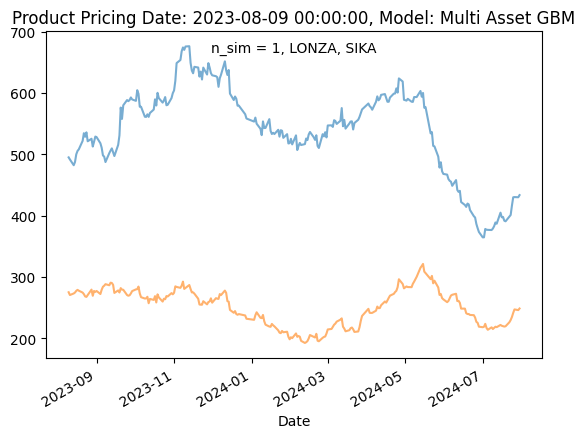

In [34]:
from yq.scripts import simulation as yqsm

for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()
        params = {
            'data': data,
            'ticker_list': ['LONN.SW', 'SIKA.SW']
        }
        sim_data_df = []
        gbm = models.PricingModel(params=params)
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])
            sim_data_df.append(sim_data)
            
            sm.store_sim_data(start_time_acc=start_time_acc,
                           model_name='gbm',
                           sim_data=sim_data,
                           product_est_date=product_est_date,
                           sim=sim)

        
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?
start = pd.Timestamp('2023-08-09')
end = pd.Timestamp('2023-08-09')

product_est_date_sim_data_df_list = yqsm.read_sim_data('gbm', '20231111_195045_022812', start, end)
sim = product_est_date_sim_data_df_list[0][0]
ax = sim.plot(alpha=0.6, legend=False)
ax.set_title(f"Product Pricing Date: {start}, Model: Multi Asset GBM")
ax.text(0.5, 0.95, f"n_sim = 1, LONZA, SIKA", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()

In [35]:
print(sim)
print(sim_interest_adjusted)

               LONN.SW     SIKA.SW
Date                              
2023-08-10  495.071653  275.078187
2023-08-11  491.667070  270.557708
2023-08-14  482.259156  273.067201
2023-08-15  487.483163  274.634728
2023-08-16  500.038604  277.364954
...                ...         ...
2024-07-24  416.334894  234.760395
2024-07-25  429.965714  241.369146
2024-07-26  430.300003  247.062289
2024-07-29  430.034470  245.947811
2024-07-30  433.517181  248.589679

[244 rows x 2 columns]
               LONN.SW     SIKA.SW
Date                              
2023-08-10  490.367562  272.464439
2023-08-11  487.038667  268.010761
2023-08-14  477.842205  270.566213
2023-08-15  483.058281  272.141870
2023-08-16  495.539968  274.869618
...                ...         ...
2024-07-24  416.305983  234.744093
2024-07-25  429.935856  241.352384
2024-07-26  430.270122  247.045132
2024-07-29  430.004608  245.930732
2024-07-30  433.487077  248.572416

[244 rows x 2 columns]


<Axes: xlabel='Date'>

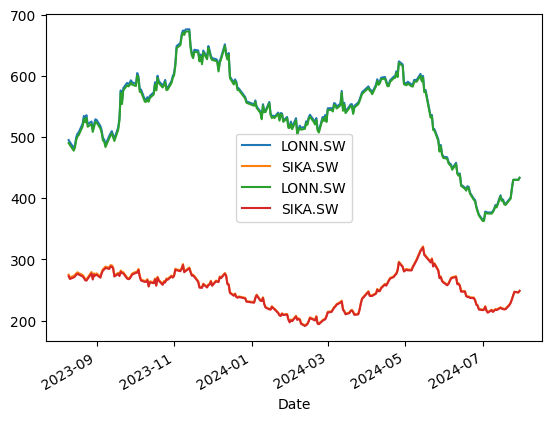

In [36]:
sim_interest_adjusted = gbm.adjust_interest_rate(bond_price, sim)
pd.concat([sim,sim_interest_adjusted],axis=1).plot()

time difference is 272.0


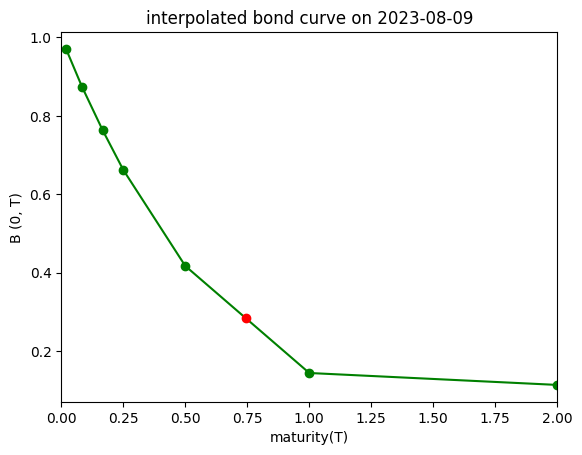

In [33]:
today = pd.Timestamp('2023-08-09')
date = pd.Timestamp('2023-11-01')

bond_table = pd.DataFrame(index=pd.date_range(today, cs.FINAL_FIXING_DATE), columns=['price'])
X = [get_period(col) for col in bond_price.columns]
Y = bond_price.loc[today].to_list()
tdelta = (cs.FINAL_FIXING_DATE - date).days/365
print(f'time difference is {tdelta*365}')
interpolated_y = np.interp(tdelta,X,Y)
plt.xlim((0,2))
plt.xlabel('maturity(T)')
plt.ylabel('B (0, T)')
plt.title('interpolated bond curve on {}'.format(today.strftime('%Y-%m-%d')))
plt.plot(X, Y, "og-", tdelta, interpolated_y, "or")

In [ ]:
# Variance reduction
today = pd.Timestamp('2023-08-09')
r = 0.0167
# calculate means
s_01  = 1
s_02 = 1.2
mu1 = s_01 * np.exp(r*(cs.FINAL_FIXING_DATE - today).days/252)
mu2 = s_02 * np.exp(r*(cs.FINAL_FIXING_DATE  - today).days/252)
print(mu1, mu2)


In [ ]:
# TODO pass me ST for lonn and sika as well as payoffs
# payoffs_cv = apply_control_variates(__place_holder__, __place_holder__, mu1, mu2, payoffs)